In [17]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import json
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score

# Import LIME libraries
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Set seeds for reproducibility
SEED = 4
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ensure reproducibility for DataLoader (shuffle behavior)
import random
random.seed(SEED)

c:\Users\USER\Desktop\UM\MAI Notes - Aidiel Haikal\7009 Explainable AI\Assignment\Alternative Assignment\Script\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the images using ImageDataGenerator (to handle image loading and preprocessing)
train_dir = "C:/Users/USER/Desktop/UM/MAI Notes - Aidiel Haikal/7009 Explainable AI/Assignment/Alternative Assignment/Script/Input/train/"
test_dir = "C:/Users/USER/Desktop/UM/MAI Notes - Aidiel Haikal/7009 Explainable AI/Assignment/Alternative Assignment/Script/Input/test/"


# Define ImageDataGenerators for scaling images for the VGG16 model
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the final model
vgg_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
vgg_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
vgg_history = vgg_model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the model
vgg_loss, vgg_accuracy = vgg_model.evaluate(test_generator)
vgg_y_pred = (vgg_model.predict(test_generator) > 0.5).astype("int32").flatten()
f1_vgg = f1_score(test_generator.classes, vgg_y_pred)

print(f"VGG16 Model - Accuracy: {vgg_accuracy*100:.2f}%, F1 Score: {f1_vgg:.2f}")

c:\Users\USER\Desktop\UM\MAI Notes - Aidiel Haikal\7009 Explainable AI\Assignment\Alternative Assignment\Script\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8235 - loss: 0.3544 - val_accuracy: 0.8686 - val_loss: 0.3170
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9137 - loss: 0.2113 - val_accuracy: 0.8862 - val_loss: 0.3099
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9270 - loss: 0.1858 - val_accuracy: 0.8830 - val_loss: 0.3085
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9314 - loss: 0.1781 - val_accuracy: 0.8702 - val_loss: 0.3439
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9302 - loss: 0.1831 - val_accuracy: 0.8654 - val_loss: 0.3461
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9386 - loss: 0.1607 - val_accuracy: 0.8862 - val_loss: 0.2806
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9322 - loss: 0.1751 - val_accuracy: 0.8926 - val_loss: 0.2706
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9333 - loss: 0.1621 - val_accu

In [4]:
# Simple CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the CNN model
cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator)
cnn_y_pred = (cnn_model.predict(test_generator) > 0.5).astype("int32").flatten()
f1_cnn = f1_score(test_generator.classes, cnn_y_pred)

print(f"CNN Model - Accuracy: {cnn_accuracy*100:.2f}%, F1 Score: {f1_cnn:.2f}")

c:\Users\USER\Desktop\UM\MAI Notes - Aidiel Haikal\7009 Explainable AI\Assignment\Alternative Assignment\Script\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 489ms/step - accuracy: 0.7736 - loss: 0.5500 - val_accuracy: 0.7901 - val_loss: 0.4244
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 488ms/step - accuracy: 0.8696 - loss: 0.3065 - val_accuracy: 0.8221 - val_loss: 0.4311
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 493ms/step - accuracy: 0.9059 - loss: 0.2250 - val_accuracy: 0.8590 - val_loss: 0.3755
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 491ms/step - accuracy: 0.9119 - loss: 0.2280 - val_accuracy: 0.8606 - val_loss: 0.3761
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 488ms/step - accuracy: 0.9324 - loss: 0.1822 - val_accuracy: 0.8894 - val_loss: 0.3374
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - accuracy: 0.9293 - loss: 0.1857 - val_accuracy: 0.9006 - val_loss: 0.3203
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.9342 - loss: 0.1711 - val_accuracy: 0.8830 - val_loss: 0.3320
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9449 - loss: 0

In [5]:
# DenseNet121
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),  # DenseNet121 input size
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),  # DenseNet121 input size
                                                  batch_size=32,
                                                  class_mode='binary')

# Load the DenseNet121 model with pre-trained weights (excluding the top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of DenseNet121 to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert the feature maps to a vector
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the dataset
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"DenseNet121 Model - Accuracy: {accuracy*100:.2f}%")

# Predict with DenseNet121
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype("int32").flatten()

# Evaluate using F1 Score
f1 = f1_score(test_generator.classes, y_pred)
print(f"DenseNet121 Model - F1 Score: {f1:.2f}")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


c:\Users\USER\Desktop\UM\MAI Notes - Aidiel Haikal\7009 Explainable AI\Assignment\Alternative Assignment\Script\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8645 - loss: 0.3354 - val_accuracy: 0.8702 - val_loss: 0.3145
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9395 - loss: 0.1584 - val_accuracy: 0.8381 - val_loss: 0.4147
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9415 - loss: 0.1394 - val_accuracy: 0.8974 - val_loss: 0.2678
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9438 - loss: 0.1466 - val_accuracy: 0.8333 - val_loss: 0.4269
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9479 - loss: 0.1311 - val_accuracy: 0.8574 - val_loss: 0.3757
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9511 - loss: 0.1271 - val_accuracy: 0.8878 - val_loss: 0.2724
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9528 - loss: 0.1142 - val_accuracy: 0.8750 - val_loss: 0.3474
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9509 - loss: 0.1195 - val_accu

In [6]:
model_dir = "C:/Users/USER/Desktop/UM/MAI Notes - Aidiel Haikal/7009 Explainable AI/Assignment/Alternative Assignment/Script/Output/"
vgg_model.save(model_dir + 'vgg_model.h5')

metrics_dict = {
    "vgg_accuracy": float(vgg_accuracy),
    "f1_vgg": float(f1_vgg),
    # "cnn_accuracy": float(cnn_accuracy),
    # "f1_cnn": float(f1_cnn),
    # "densenet121_accuracy": float(accuracy),
    # "f1_densenet121": float(f1)
}

with open(model_dir + "model_metrics.json", "w") as f:
    json.dump(metrics_dict, f)

In [14]:
def get_image_path(generator, index):
    """
    Retrieve the full image path from the generator based on the index.
    
    Args:
        generator (DirectoryIterator): The image data generator.
        index (int): Index of the desired image.
        
    Returns:
        str: Full path to the image file.
    """
    filename = generator.filenames[index]
    full_path = os.path.join(generator.directory, filename)
    return full_path

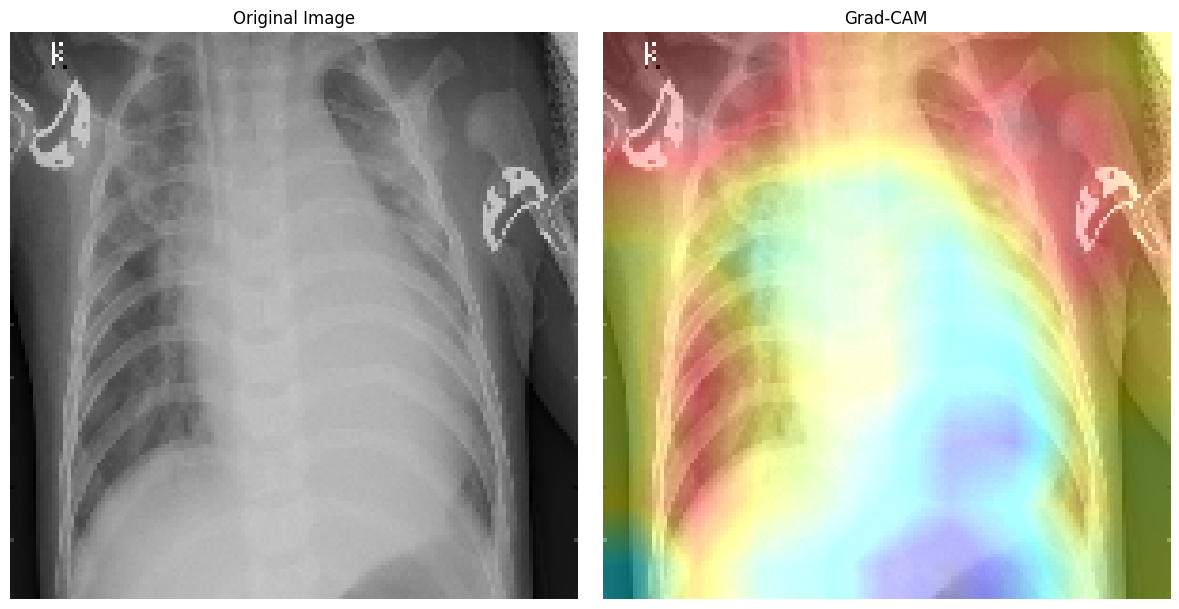

In [12]:
def display_gradcam(img_path, model, last_conv_layer_name):
    """
    Display the original image (left) and the Grad-CAM heatmap superimposed on the image (right).
    
    Args:
        img_path (str): Path to the image file.
        model (tf.keras.Model): Trained Keras model.
        last_conv_layer_name (str): Name of the last convolutional layer in the model.
    """
    # -----------------------------
    # 1) Load and preprocess the image for Grad-CAM
    # -----------------------------
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale [0,1] as done in ImageDataGenerator
    
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # -----------------------------
    # 2) Load the original image via OpenCV for display
    # -----------------------------
    original_bgr = cv2.imread(img_path)  # BGR
    original_bgr = cv2.resize(original_bgr, (150, 150))
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # -----------------------------
    # 3) Prepare the heatmap
    # -----------------------------
    # Resize heatmap to match image shape
    heatmap = cv2.resize(heatmap, (original_rgb.shape[1], original_rgb.shape[0]))
    
    # Convert heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Apply color map
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # -----------------------------
    # 4) Superimpose the heatmap
    # -----------------------------
    # Combine heatmap with original
    superimposed_img = 0.4 * heatmap_color + original_rgb
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # -----------------------------
    # 5) Display side-by-side: original vs Grad-CAM
    # -----------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Left: Original
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Right: Grad-CAM
    axes[1].imshow(superimposed_img)
    axes[1].set_title("Grad-CAM")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


image_index = 400
img_path = get_image_path(test_generator, image_index)
display_gradcam(img_path, vgg_model, 'block5_conv3')


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


  2%|▏         | 10/500 [00:00<00:18, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


  4%|▍         | 20/500 [00:00<00:18, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  6%|▌         | 30/500 [00:01<00:17, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


  8%|▊         | 40/500 [00:01<00:17, 25.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 10%|█         | 50/500 [00:02<00:21, 20.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 12%|█▏        | 60/500 [00:02<00:24, 17.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 14%|█▍        | 70/500 [00:03<00:25, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 16%|█▌        | 80/500 [00:04<00:25, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 18%|█▊        | 90/500 [00:04<00:25, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 20%|██        | 100/500 [00:05<00:26, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 22%|██▏       | 110/500 [00:06<00:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 24%|██▍       | 120/500 [00:07<00:26, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 26%|██▌       | 130/500 [00:07<00:27, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 28%|██▊       | 140/500 [00:08<00:25, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 30%|███       | 150/500 [00:09<00:24, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 32%|███▏      | 160/500 [00:09<00:24, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 34%|███▍      | 170/500 [00:10<00:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 36%|███▌      | 180/500 [00:11<00:22, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 38%|███▊      | 190/500 [00:11<00:21, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 40%|████      | 200/500 [00:12<00:20, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 42%|████▏     | 210/500 [00:13<00:19, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 44%|████▍     | 220/500 [00:13<00:18, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 46%|████▌     | 230/500 [00:14<00:17, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 48%|████▊     | 240/500 [00:15<00:16, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 50%|█████     | 250/500 [00:15<00:16, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 52%|█████▏    | 260/500 [00:16<00:16, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 54%|█████▍    | 270/500 [00:17<00:15, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 56%|█████▌    | 280/500 [00:17<00:14, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 58%|█████▊    | 290/500 [00:18<00:13, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 60%|██████    | 300/500 [00:19<00:13, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 62%|██████▏   | 310/500 [00:19<00:12, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 64%|██████▍   | 320/500 [00:20<00:11, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 66%|██████▌   | 330/500 [00:21<00:11, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 68%|██████▊   | 340/500 [00:21<00:10, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 70%|███████   | 350/500 [00:22<00:09, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 72%|███████▏  | 360/500 [00:23<00:08, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 74%|███████▍  | 370/500 [00:23<00:08, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 76%|███████▌  | 380/500 [00:24<00:07, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 78%|███████▊  | 390/500 [00:25<00:07, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 80%|████████  | 400/500 [00:25<00:06, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 82%|████████▏ | 410/500 [00:26<00:06, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 84%|████████▍ | 420/500 [00:27<00:05, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 86%|████████▌ | 430/500 [00:27<00:04, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 88%|████████▊ | 440/500 [00:28<00:03, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 90%|█████████ | 450/500 [00:29<00:03, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 92%|█████████▏| 460/500 [00:29<00:02, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 94%|█████████▍| 470/500 [00:30<00:01, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 96%|█████████▌| 480/500 [00:31<00:01, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 98%|█████████▊| 490/500 [00:31<00:00, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


100%|██████████| 500/500 [00:32<00:00, 15.40it/s]

Top predicted label: Normal (Index: 0)


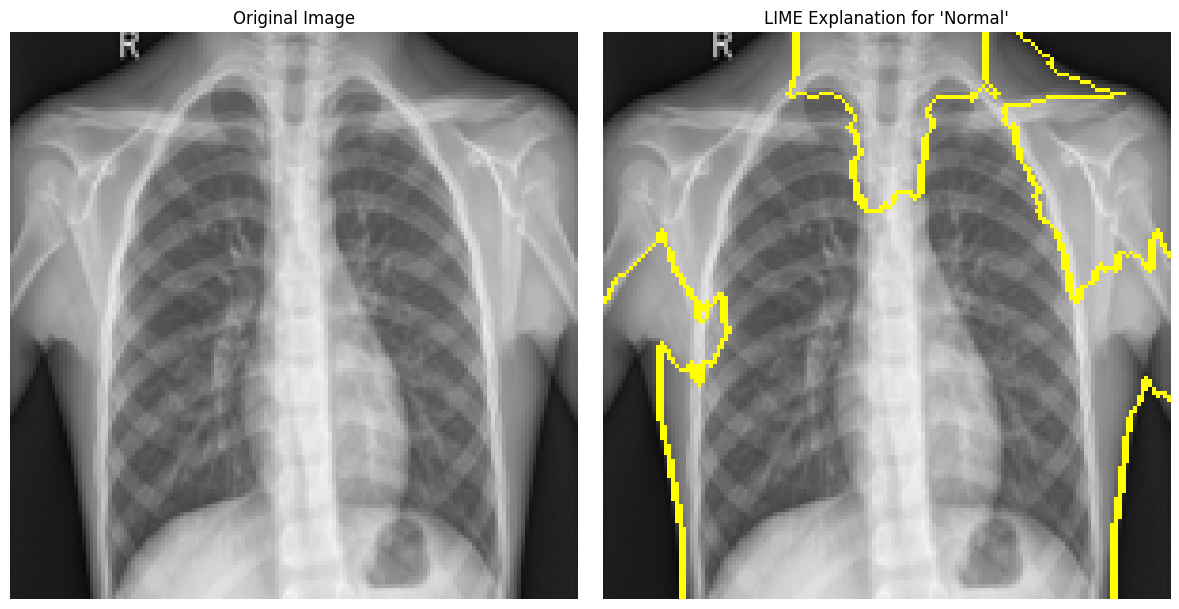

In [21]:
## LIME IMPLEMENTATION

def load_and_preprocess_image(image_path, target_size=(150, 150)):
    """
    Load and preprocess an image for LIME.
    
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size.
        
    Returns:
        numpy.ndarray: Preprocessed image array.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_np = np.array(img)
    return img_np

def lime_explanation(image_path, model, target_size=(150, 150), num_samples=1000, top_labels=1, hide_color=0, num_features=10):
    """
    Generate and display LIME explanation for a given image and model side by side with the original image.
    
    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained Keras model.
        target_size (tuple): Desired image size for the model.
        num_samples (int): Number of samples for LIME.
        top_labels (int): Number of top labels to explain.
        hide_color (int): Color to hide the superpixels.
        num_features (int): Number of features (superpixels) to highlight.
    """
    # Load and preprocess the image
    img_np = load_and_preprocess_image(image_path, target_size)
    
    # Define a prediction function for LIME
    def predict_fn(images):
        """
        Prediction function for LIME.
        
        Args:
            images (list): List of images as numpy arrays.
            
        Returns:
            numpy.ndarray: Array of probabilities.
        """
        images = np.array(images)
        images = images / 255.0  # Rescale as done in ImageDataGenerator
        predictions = model.predict(images)
        return predictions
    
    # Initialize LIME Image Explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Generate LIME explanation
    explanation = explainer.explain_instance(
        img_np, 
        predict_fn, 
        top_labels=top_labels, 
        hide_color=hide_color, 
        num_samples=num_samples
    )
    
    # Get the top predicted label
    top_pred = explanation.top_labels[0]
    # Assuming binary classification: 0 - Normal, 1 - Pneumonia
    class_mapping = {0: 'Normal', 1: 'Pneumonia'}
    label_name = class_mapping.get(top_pred, f"Class {top_pred}")
    
    print(f"Top predicted label: {label_name} (Index: {top_pred})")
    
    # Get image and mask for the top predicted label
    temp, mask = explanation.get_image_and_mask(
        top_pred, 
        positive_only=True, 
        num_features=num_features, 
        hide_rest=False
    )
    
    # Superimpose LIME explanation on the original image
    plt.figure(figsize=(12, 6))
    
    # Left: Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    
    # Right: LIME Explanation
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for '{label_name}'")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example Usage:

# Choose an image index from the test_generator
# For example, index 0
image_index = 0
img_path = get_image_path(test_generator, image_index)

# Generate LIME explanation for the chosen image using VGG16 model
lime_explanation(img_path, vgg_model, target_size=(150, 150), num_samples=500, top_labels=1, hide_color=0, num_features=10)
